In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.data.external import *
from local.notebook.showdoc import show_doc
from local.optimizer import *
from local.learner import *

In [ ]:
#default_exp callback.progress

# Progress and logging callbacks

> Callback and helper function to track progress of training or log results

In [ ]:
from local.utils.test import *

## ProgressCallback -

In [ ]:
@docs
class ProgressCallback(Callback):
    "A `Callback` to handle the display of progress bars"
    order = 30 #needs to run after the Recorder
    def begin_fit(self):
        assert hasattr(self.learn, 'recorder')
        self.mbar = master_bar(list(range(self.n_epoch)))
        self.mbar.on_iter_begin()
        self.old_logger,self.learn.logger = self.logger,self._write_stats
        self._write_stats(self.recorder.metric_names)
    
    def begin_epoch(self):    self.mbar.update(self.epoch)
    def begin_train(self):    self._launch_pbar()
    def begin_validate(self): self._launch_pbar()
    def after_train(self):    self.pbar.on_iter_end()
    def after_validate(self): self.pbar.on_iter_end()
    def after_batch(self):    self.pbar.update(self.iter+1)
        
    def _launch_pbar(self):
        self.pbar = progress_bar(self.dl, parent=self.mbar)
        self.pbar.update(0)
        
    def after_fit(self):      
        self.mbar.on_iter_end()
        self.learn.logger = self.old_logger
    
    def _write_stats(self, log):
        self.mbar.write([f'{l:.6f}' if isinstance(l, float) else str(l) for l in log], table=True)
        
    _docs = dict(begin_fit="Setup the master bar over the epochs",
                 begin_epoch="Update the master bar",
                 begin_train="Launch a progress bar over the training dataloader",
                 begin_validate="Launch a progress bar over the validation dataloader",
                 after_train="Close the progress bar over the training dataloader",
                 after_validate="Close the progress bar over the validation dataloader",
                 after_batch="Update the current progress bar",
                 after_fit="Close the master bar")
        
defaults.callbacks = [TrainEvalCallback, Recorder, ProgressCallback]

In [ ]:
learn = synth_learner()
learn.fit(5)

epoch,train_loss,valid_loss,time
0,8.031000,0.873810,00:00
1,0.540734,0.933880,00:00
2,1.071795,0.229442,00:00
3,0.104807,0.064599,00:00
4,0.113735,0.054114,00:00


In [ ]:
show_doc(ProgressCallback.begin_fit)

<h4 id="<code>ProgressCallback.begin_fit</code>" class="doc_header"><code>ProgressCallback.begin_fit</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L5" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.begin_fit</code>()

Setup the master bar over the epochs

In [ ]:
show_doc(ProgressCallback.begin_epoch)

<h4 id="<code>ProgressCallback.begin_epoch</code>" class="doc_header"><code>ProgressCallback.begin_epoch</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.begin_epoch</code>()

Update the master bar

In [ ]:
show_doc(ProgressCallback.begin_train)

<h4 id="<code>ProgressCallback.begin_train</code>" class="doc_header"><code>ProgressCallback.begin_train</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L12" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.begin_train</code>()

Launch a progress bar over the training dataloader

In [ ]:
show_doc(ProgressCallback.begin_validate)

<h4 id="<code>ProgressCallback.begin_validate</code>" class="doc_header"><code>ProgressCallback.begin_validate</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L13" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.begin_validate</code>()

Launch a progress bar over the validation dataloader

In [ ]:
show_doc(ProgressCallback.after_batch)

<h4 id="<code>ProgressCallback.after_batch</code>" class="doc_header"><code>ProgressCallback.after_batch</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L16" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.after_batch</code>()

Update the current progress bar

In [ ]:
show_doc(ProgressCallback.after_train)

<h4 id="<code>ProgressCallback.after_train</code>" class="doc_header"><code>ProgressCallback.after_train</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L14" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.after_train</code>()

Close the progress bar over the training dataloader

In [ ]:
show_doc(ProgressCallback.after_validate)

<h4 id="<code>ProgressCallback.after_validate</code>" class="doc_header"><code>ProgressCallback.after_validate</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L15" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.after_validate</code>()

Close the progress bar over the validation dataloader

In [ ]:
show_doc(ProgressCallback.after_fit)

<h4 id="<code>ProgressCallback.after_fit</code>" class="doc_header"><code>ProgressCallback.after_fit</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L22" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.after_fit</code>()

Close the master bar

## ShowGraphCallback -

In [ ]:
class ShowGraphCallback(Callback):
    "Update a graph of training and validation loss"
    order=35 #Need to run after ProgressCallback
    def begin_fit(self): 
        self.nb_batches = []
        assert hasattr(self.learn, 'progress')
    
    def after_train(self): self.nb_batches.append(self.train_iter)
    
    def after_epoch(self):
        "Plot validation loss in the pbar graph"
        rec = self.learn.recorder
        iters = range_of(rec.losses)
        val_losses = [v[1] for v in rec.values]
        x_bounds = (0, (self.n_epoch - len(self.nb_batches)) * self.nb_batches[0] + len(rec.losses))
        y_bounds = (0, max((max(Tensor(rec.losses)), max(Tensor(val_losses)))))
        self.progress.mbar.update_graph([(iters, rec.losses), (self.nb_batches, val_losses)], x_bounds, y_bounds)

epoch,train_loss,valid_loss,time
0,19.840519,3.645988,00:00
1,1.030220,2.488881,00:00
2,2.087567,1.090319,00:00
3,0.289248,0.042914,00:00
4,0.135158,0.167123,00:00
5,0.074568,0.016952,00:00
6,0.015842,0.034150,00:00
7,0.018934,0.019462,00:00
8,0.010643,0.016210,00:00
9,0.011006,0.016276,00:00


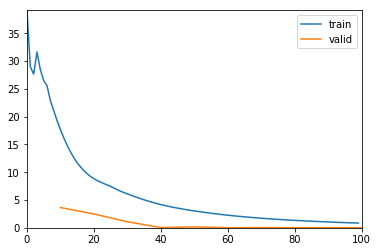

In [ ]:
learn = synth_learner(cbs=ShowGraphCallback())
learn.fit(10)